# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [168]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime
import pandas as pd

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [171]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [173]:
cursor = con.cursor()

In [175]:
cursor.execute("""
    SELECT MIN(hire_date), MAX(hire_date)
    FROM employees;
""")

In [177]:
cursor.fetchall()

[(datetime.date(1985, 1, 1), datetime.date(2000, 1, 28))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [179]:
cursor.execute("""
SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries s
JOIN (
    SELECT emp_no, MAX(to_date) AS max_to_date
    FROM salaries
    GROUP BY emp_no
) latest_salary
ON s.emp_no = latest_salary.emp_no
AND s.to_date = latest_salary.max_to_date
ORDER BY s.emp_no;
""")

In [181]:
result = cursor.fetchall()
field_names = [i[0] for i in cursor.description]
res = pd.DataFrame(result, columns=field_names)

In [183]:
print(res.columns.tolist(), res.shape)
print(res.head(3))

['emp_no', 'salary', 'from_date', 'to_date'] (300180, 4)
   emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01


Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [185]:
res.dtypes

emp_no        int64
salary        int64
from_date    object
to_date      object
dtype: object

In [187]:
print(res['to_date'].unique())

[datetime.date(9999, 1, 1) datetime.date(2000, 7, 31)
 datetime.date(1996, 11, 9) ... datetime.date(1986, 7, 18)
 datetime.date(1988, 5, 3) datetime.date(1987, 8, 25)]


In [216]:
target_date = datetime.date(9999, 1, 1)
count_9999_01_01 = (res['to_date'] == target_date).sum()
count_not_9999_01_01 = (res['to_date'] != target_date).sum()

print(f"Кількість значень to_date, які дорівнюють 9999-01-01: {count_9999_01_01}")
print(f"Кількість значень to_date, які не дорівнюють 9999-01-01: {count_not_9999_01_01}")

Кількість значень to_date, які дорівнюють 9999-01-01: 240124
Кількість значень to_date, які не дорівнюють 9999-01-01: 60056


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

In [234]:
import matplotlib.pyplot as plt


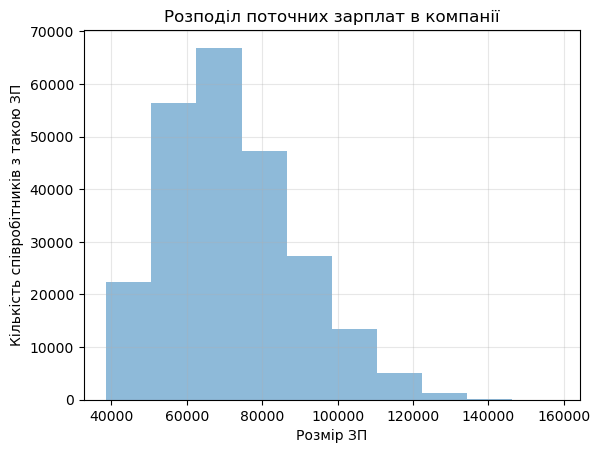

In [236]:
current_employees = res[res['to_date'] == target_date]

current_employees['salary'].plot.hist(bins=10, alpha=0.5)
plt.grid(axis='both', alpha=.3)
plt.title('Розподіл поточних зарплат в компанії')
plt.xlabel('Розмір ЗП')
plt.ylabel('Кількість співробітників з такою ЗП')
plt.show()

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [238]:
con.close()